In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data

#os.environ['TF_NUM_INTEROP_THREADS'] = '10'
#os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
#tf.config.threading.set_inter_op_parallelism_threads(10)
#tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
data_label = "data"
predict_label = "label"
labels = None
class_weights = False
sample_weights = False

In [3]:
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64
epochs = 10
batch_size = 32

# Unbalanced

Training set size: 27154
Validation set size: 9051
Test set size: 9052
label
meniskus_urgent    11064
other               9523
cruciate_urgent     3882
meniskus_low        1549
other_urgent         905
cruciate_low         231
Name: count, dtype: int64


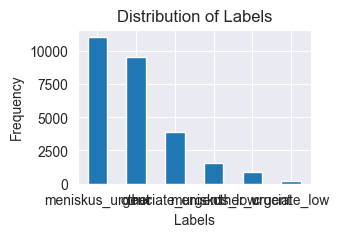

In [4]:
df = pd.read_csv('../data/balanced_classification_dataset.csv')

balanced = False
train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = get_train_test_data(df, data_label, predict_label, balanced=balanced, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

In [5]:
# Define model parameters
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(average="macro", name='f1_score'),
]
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

2024-07-22 19:19:25.952005: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-22 19:19:25.952057: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-22 19:19:25.952070: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-22 19:19:25.952098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-22 19:19:25.952127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_base = Model(inputs=input_text, outputs=output)

# Compile the model
model_base.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_base = model_base.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/10


2024-07-22 19:19:31.765921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  9/849 ━━━━━━━━━━━━━━━━━━━━ 22:20 2s/step - accuracy: 0.3895 - auc: 0.7578 - f1_score: 0.1404 - loss: 1.6593

In [ ]:
eval_training(history_base, metrics)

In [ ]:
eval(model_base, test_padded, test_labels, label_encoder, "../data/lstm_eval/unbalanced.csv")

# Balanced

Training set size: 1386
Validation set size: 462
Test set size: 462
label
other              231
cruciate_urgent    231
meniskus_low       231
cruciate_low       231
other_urgent       231
meniskus_urgent    231
Name: count, dtype: int64


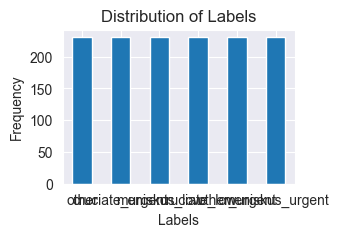

In [9]:
df = pd.read_csv('../data/balanced_classification_dataset.csv')

balanced = True
train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = get_train_test_data(df, data_label, predict_label, balanced=balanced, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

In [10]:
# Define model parameters
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(name='f1_score'),
]

In [11]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_balanced = Model(inputs=input_text, outputs=output)

# Compile the model
model_balanced.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
history_balanced = model_balanced.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.1866 - auc: 0.5359 - f1_score: 0.1504 - loss: 1.7815 - val_accuracy: 0.3030 - val_auc: 0.6821 - val_f1_score: 0.2587 - val_loss: 1.6537
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.4105 - auc: 0.7515 - f1_score: 0.3770 - loss: 1.5306 - val_accuracy: 0.3420 - val_auc: 0.7156 - val_f1_score: 0.3173 - val_loss: 1.5894
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.5939 - auc: 0.8776 - f1_score: 0.5765 - loss: 1.1669 - val_accuracy: 0.3225 - val_auc: 0.6730 - val_f1_score: 0.3254 - val_loss: 1.7573
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.7644 - auc: 0.9497 - f1_score: 0.7635 - loss: 0.7809 - val_accuracy: 0.3095 - val_auc: 0.6776 - val_f1_score: 0.3084 - val_loss: 1.9649
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.8950 - auc: 0.9864 - f1_score: 0.8932 - loss: 0.4063 - val_accuracy: 0.3355 - val_auc: 0.6700 - val_f1_score: 0.3338 - val_lo

# Evaluation

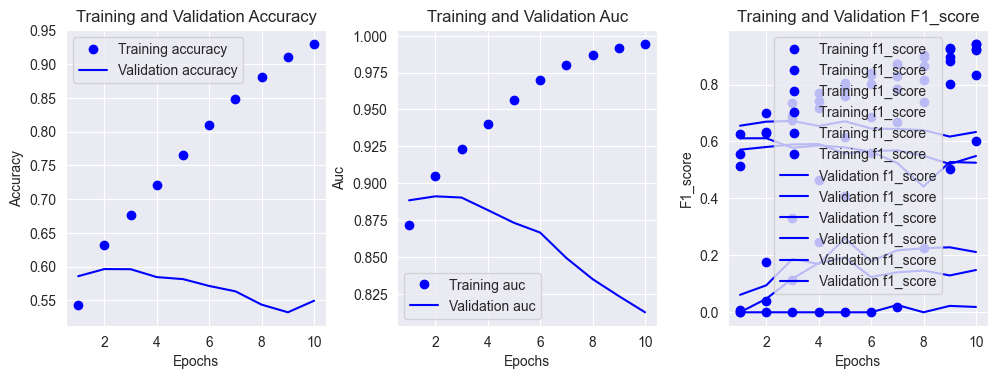

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


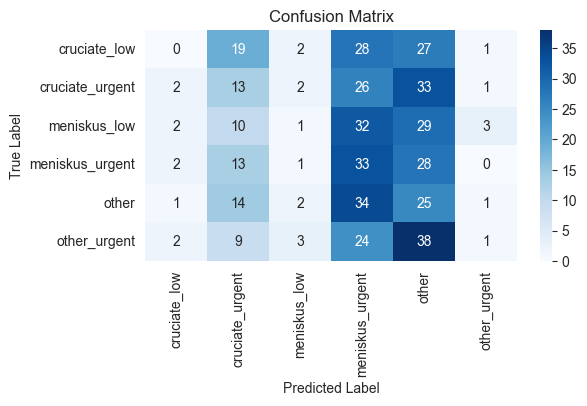

F1: 0.15800865800865802


In [13]:
eval_training(history_base, metrics)
eval(model_base, test_padded, test_labels, label_encoder)

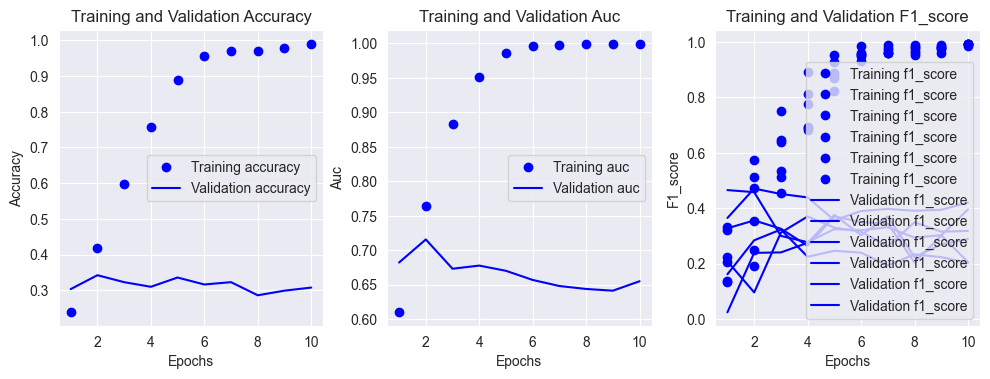

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


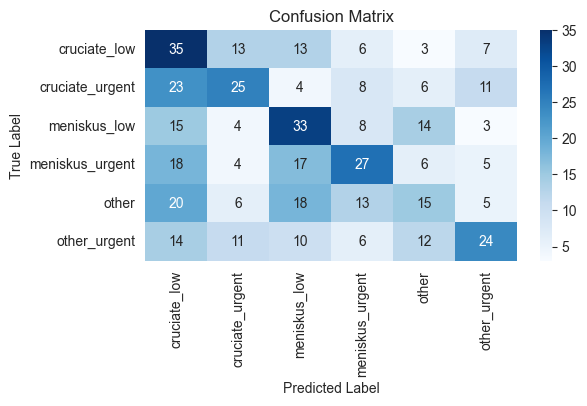

F1: 0.34415584415584416


In [15]:
eval_training(history_balanced, metrics)
eval(model_balanced, test_padded, test_labels, label_encoder)